In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('figures.mplstyle')

from global_variables import *
from lv import *
from flux import *

from scipy.interpolate import interp1d
from scipy.stats import norm
import vegas
from functools import partial

In [3]:
# Rate of neutrino interactions / dR / dE
# Units: (Number of Interactions) / m / GeV
def rate(flux, xsec, Enu, R, P, baseline):
    costh = np.cos(R/baseline)
    ret = flux(Emuon, P, Enu, costh, baseline)*xsec(Enu)*MASS*(4*np.pi*R*np.sqrt(RADIUS**2 - R**2)/VOLUME)
    if not isinstance(ret, float):
        ret[R > RADIUS] = 0
    elif R > RADIUS:
        return 0
    return ret
    
def numu_rate(Enu, R, P, baseline):
    return rate(numu_flux_baseline, xsec, Enu, R, P, baseline)

def integrand(x, baseline):
    Enu, R = x  # x will be a 2D vector [Enu, R]
    return numu_rate(Enu, R, P, baseline)

# Perform the integration over specified ranges
def perform_integration(experiment):
    # Define the ranges for Enu and R
    Enu_min, Enu_max = Emuon/10, Emuon  # Replace with actual range
    R_min, R_max = 0.0, RADIUS  # Ensure R is within the allowed radius
    
    # Set up the integrator
    integ = vegas.Integrator([[Enu_min, Enu_max], [R_min, R_max]])

    integrand_partial = partial(integrand, baseline=baseline_list[experiment])
    
    # Perform the integration
    result = integ(integrand_partial, nitn=20, neval=1000)
    #print(result.summary())
    print('Integral =', result, '    Q =', result.Q)
    return result.val


In [117]:
nYears = 10
throughgoing_factor = 3
straight_section_factor = 100 / 0.3 # 100 m v.s. 0.3 m

nEvents_dict = {"IC":perform_integration("IC")*nYears*throughgoing_factor,
                "KM3":perform_integration("KM3")*nYears*throughgoing_factor,
                "PONE":perform_integration("PONE")*nYears*throughgoing_factor*straight_section_factor}
nTrials = int(1e5)
highest_mode = 5
nBins = int(2**highest_mode)+1
t_bins = np.linspace(0,1,nBins+1)
t_bin_centers = (t_bins[1:] + t_bins[:-1])/2

def get_amplitudes(events):
    fft = np.abs(np.fft.fft(events))
    amps = np.zeros(nBins)
    amps[0] = fft[0]/nBins
    amps[1:] = 2*fft[1:]/nBins
    amps /= amps[0]
    return amps


Integral = 3.439(11)e+08     Q = 0.2925238007957229
Integral = 3.615(13)e+08     Q = 0.021611412437279525
Integral = 3.700(15)e+08     Q = 0.19296354560685425


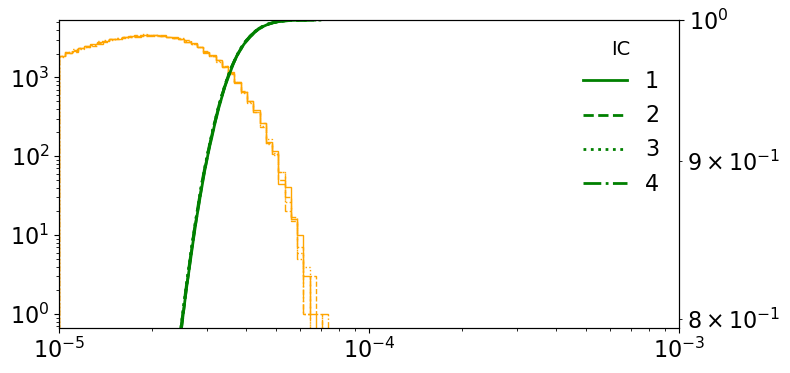

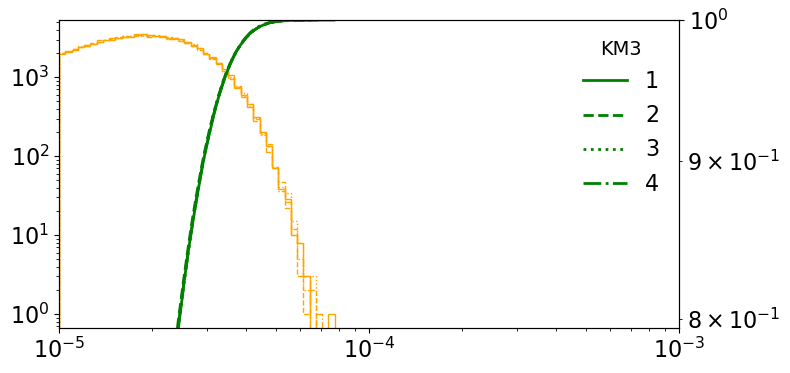

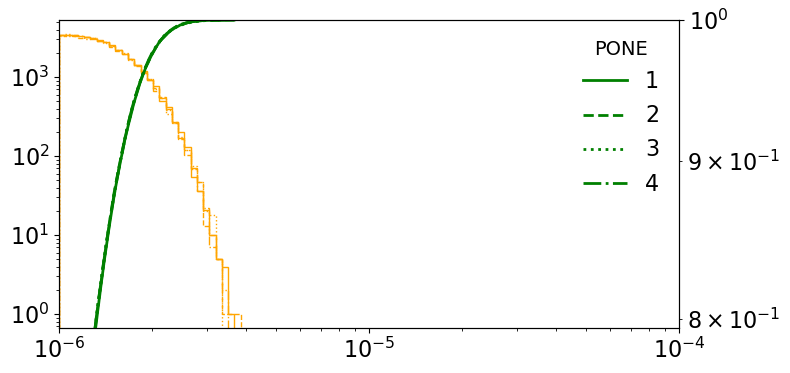

In [118]:
amplitudes = {}
quantile_points = np.logspace(-0.1,0,nTrials)
sensitivity_quantiles = [1-((1-norm.cdf(n))*2) for n in [1,2,3,4]]
sensitivity_quantiles += [0.9]
exp_sensitivities = {}
amplitude_bins = np.logspace(-5,-3,100)
for exp,nEvents in nEvents_dict.items():
    amplitude_bins = np.logspace(-5,-3,100)
    if exp=="PONE": amplitude_bins /= 10
    amps = np.empty((nTrials,nBins))
    poisson_throws = np.random.poisson(nEvents/(nBins),(nTrials,nBins))
    for nT,n in enumerate(poisson_throws):
        amps[nT] = get_amplitudes(n)
        # fft = np.abs(np.real(np.fft.fft(n)))
        # amps[nT][0] = fft[0]/nBins
        # amps[nT][1:] = 2*fft[1:]/nBins
        # amps[nT] /= amps[nT][0]
    amplitudes[exp] = amps
    
    fig = plt.figure()
    ax1 = plt.gca()
    ax2 = plt.gca().twinx()
    for mode,ls in zip([1,2,3,4],["-","--",":","-."]):
        ax1.hist(amps[:,mode],color="orange",bins=amplitude_bins,ls=ls,histtype="step")
        
        quantiles = np.quantile(amps[:,mode],quantile_points)
        ax2.plot(quantiles,quantile_points,color="green",ls=ls,label=mode)
        exp_sens = np.quantile(amps[:,mode],sensitivity_quantiles)
        exp_sensitivities[(exp,mode)] = {quant:sens for quant,sens in zip(sensitivity_quantiles,exp_sens)}
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax1.set_xlim(amplitude_bins[0],amplitude_bins[-1])
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax2.set_ylim(quantile_points[0],quantile_points[-1])
    plt.legend(title=exp)
    plt.show()
    plt.close(fig)



## but how does amplitude correspond to PSD?

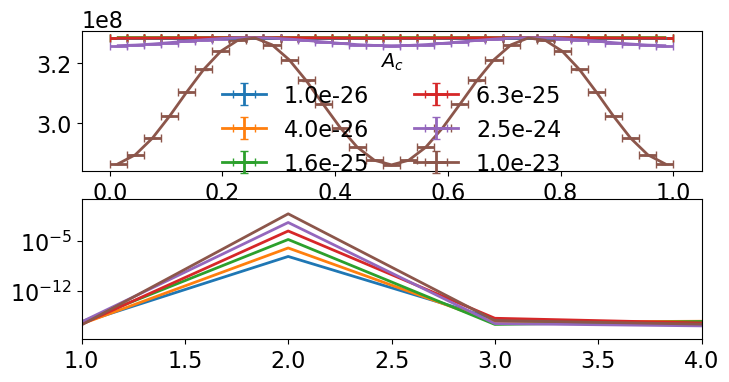

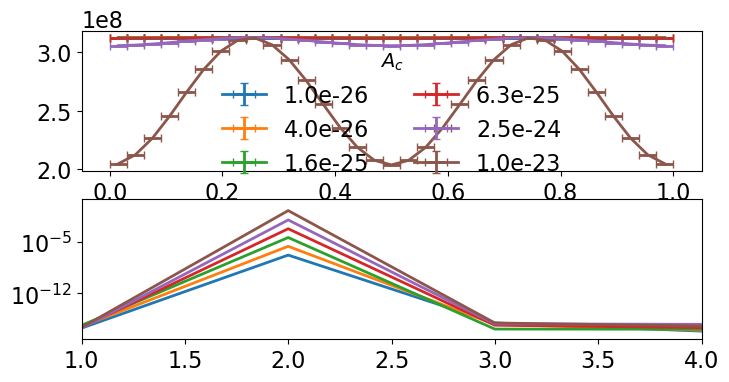

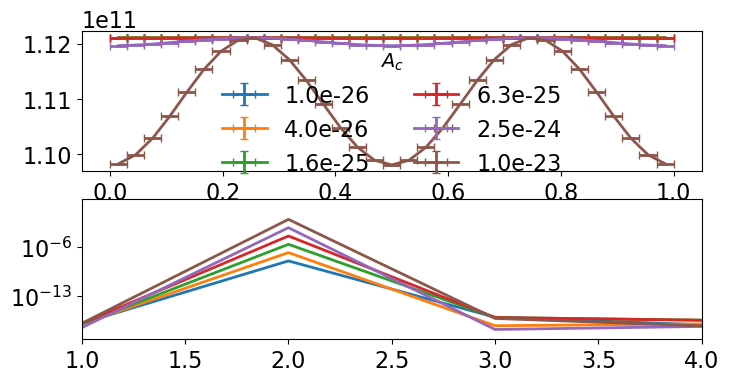

In [119]:
Ac_list = np.logspace(-26,-23,6)
mode2_amps = {}
for exp in experiment_list:
    amp = np.empty(int(nBins/2-1))
    fig,ax = plt.subplots(2,1)
    mode2_amps[exp] = []
    for Ac in Ac_list:
        events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],t_bin_centers,Ac=Ac)
        # fft = np.abs(np.abs(np.fft.fft(events)))[:int(nBins/2)-1]
        # amp[0] = fft[0]/nBins
        # amp[1:] = 2*fft[1:]/nBins
        # amp/= amp[0]
        amp = get_amplitudes(events)
        mode2_amps[exp].append(amp[2])
        ax[0].errorbar(t_bin_centers,events,xerr=(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events),capsize=3,label="%1.1e"%Ac)
        ax[1].plot(amp)
    ax[0].legend(ncol=2,title=r"$A_c$")
    #ax[0].semilogy()
    ax[1].semilogy()
    #ax[1].set_ylim(1e-6,1e-2)
    ax[1].set_xlim(1,4)
    plt.show()
    plt.close(fig)



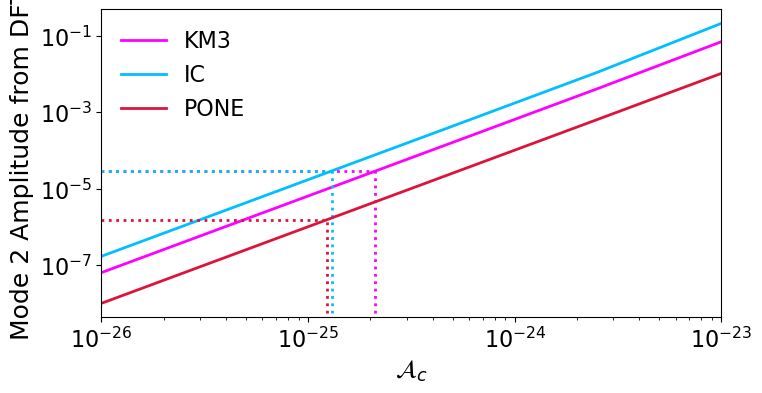

In [120]:
Ac_upper_limit = {}
for exp in experiment_list:
    Ac_interp = interp1d(np.log10(mode2_amps[exp]),np.log10(Ac_list))
    amp_upper_limit = exp_sensitivities[(exp,2)][0.9]
    Ac_upper_limit[exp] = 10**Ac_interp(np.log10(amp_upper_limit))
    plt.plot(Ac_list,mode2_amps[exp],label=exp,color=color_list[exp])
    plt.plot([Ac_list[0],Ac_upper_limit[exp]],
             [amp_upper_limit,amp_upper_limit],
             color=color_list[exp],ls=":")
    plt.plot([Ac_upper_limit[exp],Ac_upper_limit[exp]],
             [0,amp_upper_limit],
             color=color_list[exp],ls=":")
plt.xlabel(r"$\mathcal{A}_c$")
plt.ylabel("Mode 2 Amplitude from DFT")
plt.loglog()
plt.legend()
plt.xlim(Ac_list[0],Ac_list[-1])
plt.show()

# Now in terms of the bare LIV coefficients

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_2552/2943216123.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inset = plt.gca().inset_axes([0.5, 0.76, 0.35, 0.2],


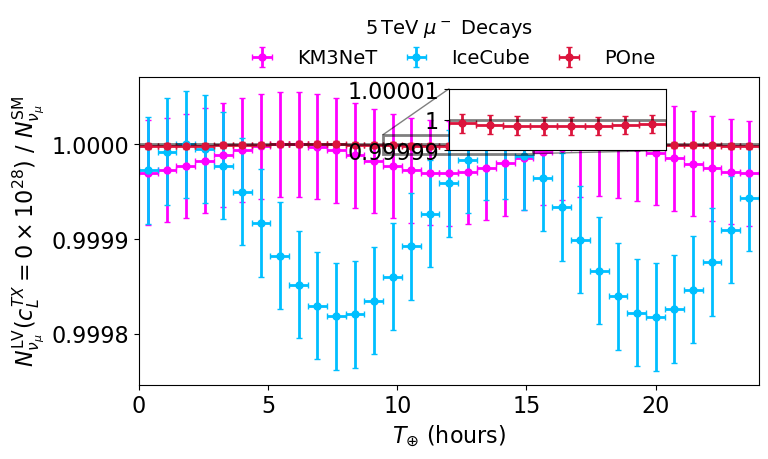

In [131]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure()
ax = plt.gca()
aL_vec = np.zeros(4,dtype=float)
cL_vec = np.zeros((4,4),dtype=float)
cL_vec[0,1] = 4e-29 # for example
#aL_vec[3] = 2e-23 # for example
LVsv = LV_sidreal_variations(aL_vec,cL_vec)
plot_lines = []
test_amplitudes = {}
for exp in experiment_list:
    C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp)
    nominal = (nEvents_dict[exp]/nBins)
    events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                                t_bin_centers,
                                                C=C,
                                                Ac=Ac,As=As,
                                                Bc=Bc,Bs=Bs)
    test_amplitudes[exp] = get_amplitudes(events)
    plot_lines.append(
        plt.errorbar(t_bin_centers*24,events/nominal,xerr=24*(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,
                     color=color_list[exp],capsize=2,label=exp,fmt=".")
    )
plt.plot([0,24],[1,1],color="black",alpha=0.5,ls="-")
plt.xlim(0,24)
#plt.ylim(0.9985,1.001)
#plt.semilogy()
plt.xlabel(r"$T_{\oplus}$ (hours)",fontsize=16)
plt.ylabel(r"$N^{\rm LV}_{\nu_\mu}(c_L^{TX} = %1.0f \times 10^{28})~/~N^{\rm SM}_{\nu_\mu}$"%(cL_vec[0,1]/1e-28),fontsize=16)
p0 = plt.plot([],[])
# plt.text(0.57,0.05,
#          r"$c_L^{TX} = %1.0f \times 10^{28}$"%(cL_vec[0,1]/1e-28),
#          fontsize=16,
#          horizontalalignment='center', verticalalignment='center',
#          transform=plt.gca().transAxes)
#"Baseline:\nChicago" + r"$\to$"] + 
plt.legend(plot_lines,[experiment_names[exp] for exp in experiment_list], 
            ncol=3, fontsize=14, columnspacing=1, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, 1.25),
           title=r"$5\,{\rm TeV}~\mu^-$ Decays",title_fontsize=14)


# zoomed in axis

# Define the limits for the inset (zoomed-in section)
x1, x2, y1, y2 = 24*t_bins[13], 24*t_bins[21], 0.99999, 1.00001
# Add an inset axes
ax_inset = plt.gca().inset_axes([0.5, 0.76, 0.35, 0.2],
                                xlim=(x1, x2),ylim=(y1, y2),
                                xticklabels=[],
                                yticklabels=[y1,1,y2],
                                xticks=[],
                                yticks=[y1,1,y2]
                               )


ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)

exp = "PONE"
C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp)
nominal = (nEvents_dict[exp]/nBins)
events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                            t_bin_centers,
                                            C=C,
                                            Ac=Ac,As=As,
                                            Bc=Bc,Bs=Bs)
test_amplitudes[exp] = get_amplitudes(events)
ax_inset.errorbar(t_bin_centers*24,events/nominal,xerr=24*(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,
             color=color_list[exp],capsize=2,fmt=".")
ax_inset.plot([x1,x2],[1,1],color="black",alpha=0.5,ls="-")

ax.indicate_inset_zoom(ax_inset, edgecolor="black",lw=2)


plt.savefig("figures/LV_sidereal.pdf",dpi=100,bbox_inches='tight')
plt.show()

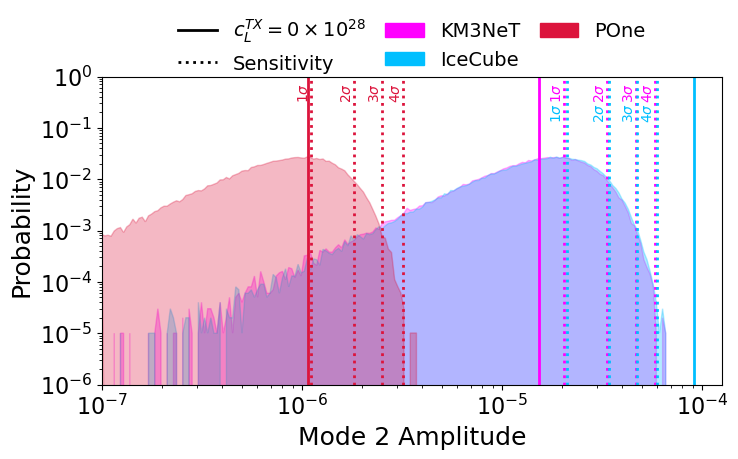

In [133]:
mode = 2
amplitude_bins = np.logspace(-7,-3.9,200)
amplitdue_bw = amplitude_bins[1:] - amplitude_bins[:-1]
plt.plot([],[],color="black",ls="-",label=r"$c_L^{TX} = %1.0f \times 10^{28}$"%(cL_vec[0,1]/1e-28))
plt.plot([],[],color="black",ls=":",label="Sensitivity")
for exp in experiment_list:
    rates,_ = np.histogram(amplitudes[exp][:,mode],bins=amplitude_bins)
    y = 1.*rates#/amplitdue_bw
    y /= sum(y)
    plt.fill([],[],color=color_list[exp],label=experiment_names[exp])
    plt.fill(amplitude_bins[:-1],y,color=color_list[exp],alpha=0.3)
    plt.axvline(test_amplitudes[exp][mode],color=color_list[exp])
    for sens_level_idx in range(4):
        sens_level = sensitivity_quantiles[sens_level_idx]
        plt.axvline(exp_sensitivities[(exp,mode)][sens_level],color=color_list[exp],ls=":")
        height = 5e-1
        x = exp_sensitivities[(exp,mode)][sens_level]
        if exp=="IC":
            height = 2e-1
            x = exp_sensitivities[("KM3",mode)][sens_level]
        plt.text(x,height,r"$%d\sigma$"%(sens_level_idx+1),
                 horizontalalignment='right', verticalalignment='center', 
                 color=color_list[exp],rotation=90)
plt.xlim(amplitude_bins[0],amplitude_bins[-1])
plt.loglog()
plt.ylim(1e-6,1)
plt.ylabel("Probability")
plt.xlabel("Mode %d Amplitude"%mode)

plt.legend(ncol=3, fontsize=14, columnspacing=1, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, 1.25))

plt.savefig("figures/amplitude_dist.pdf",dpi=100,bbox_inches='tight')
plt.show()

In [134]:
aL_range = np.logspace(-26.5,-22.9,30)
cL_range = np.logspace(-30.5,-26.5,30)
aL_amps = {}
cL_amps = {}
for aL in aL_range:
    for pos in range(4):
        aL_vec = np.zeros(4)
        aL_vec[pos] = aL
        LVsv = LV_sidreal_variations(aL_vec,np.zeros((4,4)))
        for exp in experiment_list:
            C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp)
            events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                              t_bin_centers,
                                              C=C,
                                              Ac=Ac,As=As,
                                              Bc=Bc,Bs=Bs)
            aL_amps[(exp,pos,aL)] = get_amplitudes(events)

for cL in cL_range:
    for pos1 in range(4):
        for pos2 in range(4):
            cL_vec = np.zeros((4,4))
            cL_vec[pos1,pos2] = cL
            LVsv = LV_sidreal_variations(np.zeros(4),cL_vec)
            for exp in experiment_list:
                C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp)
                events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                                  t_bin_centers,
                                                  C=C,
                                                  Ac=Ac,As=As,
                                                  Bc=Bc,Bs=Bs)
                cL_amps[(exp,pos1,pos2,cL)] = get_amplitudes(events)


            
            #nominal = (nEvents_dict[exp]/nBins)
        
    #     plt.errorbar(t_bin_centers,events/nominal - 1,xerr=(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,capsize=3,label=exp,fmt='.')
    # plt.plot([0,1],[0,0],color="grey",ls="-")
    # plt.ylabel("(LV - SM)/SM")
    # plt.xlabel(r"Local Sidereal Phase")
    # plt.legend(title=r"$\mathcal{A}_c/(10^{-21}) = %1.1f$"%(Ac/1e-21))
    # plt.xlim(0,1)
    # plt.show()

Warning! We are not in the short baseline regime. perturbation term reaches 1.1
Warning! We are not in the short baseline regime. perturbation term reaches 1.3


In [135]:
def plot_upper_limit(amp_uppper_limit,
                     coeff_points,
                     amp_points,
                     ax,color):
    coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))
    coeff_upper_limit = 10**coeff_interp(np.log10(amp_upper_limit))
    ax.plot([coeff_points[0],coeff_upper_limit],
            [amp_upper_limit,amp_upper_limit],
             color=color,ls=":")
    ax.axvline(coeff_upper_limit,color=color,ls=":")
    return coeff_upper_limit

sens_level = sensitivity_quantiles[2] # 3 sigma
lorentz_index = {0:"T",
                 1:"X",
                 2:"Y",
                 3:"Z"}

# IceCube atmospherics: https://arxiv.org/abs/1010.4096
IC_upper_limit_aL = {1:1.7e-23,
                     2:1.7e-23,}

IC_upper_limit_cL = {(0,1):7.9e-27,
                     (0,2):7.9e-27}

# MINOS far detector: https://arxiv.org/pdf/1007.2791
MINOS_upper_limit_aL = {1:5.9e-23,
                        2:6.1e-23,}

MINOS_upper_limit_cL = {(0,1):0.5e-23,
                        (1,1):2.5e-23,
                        (1,2):1.2e-23,
                        (1,3):0.7e-23,
                        (0,2):0.5e-23,
                        (2,2):2.4e-23,
                        (2,3):0.7e-23}

aL_max = 2e-22
cL_max = 2e-22
amp_min = 2e-6
amp_max = 2e-3

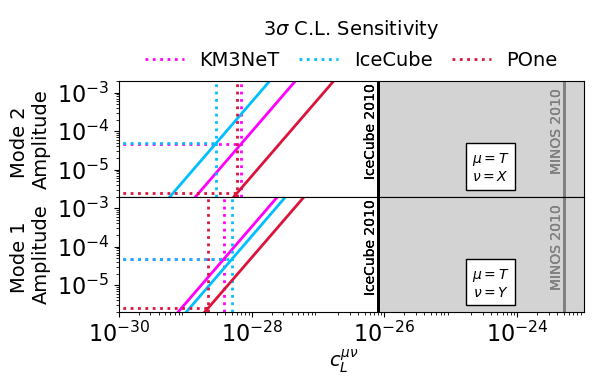

In [136]:
import matplotlib.ticker as ticker

mode = 2

fig,ax = plt.subplots(2,1,sharex=True,figsize=(6,3))
plt.subplots_adjust(wspace=0, hspace=0)

fig.supxlabel(r"$c_L^{\mu \nu}$",fontsize=14,y=-0.1)
# ax[0].plot([],[],color="black",ls="-",label="IceCube 2010")
# ax[0].plot([],[],color="gray",ls="-",label="MINOS 2010")
pos1 = 0
for exp in experiment_list:
    amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
    ax[0].plot([],[],color=color_list[exp],ls=":",label=experiment_names[exp])
    for pos2 in [1,2]:
        mode = 1 if pos2==2 else 2
        ax[pos2-1].set_ylabel("Mode %d \nAmplitude"%mode,fontsize=14)
        amps_per_cL = [cL_amps[(exp,pos1,pos2,cL)][mode] for cL in cL_range]
        if (amps_per_cL[-1]/amps_per_cL[0] < 10): continue
        ax[pos2-1].plot(cL_range,amps_per_cL,color=color_list[exp])
        plot_upper_limit(amp_upper_limit,cL_range,amps_per_cL,ax[pos2-1],color_list[exp])

        # IceCube limits 
        if (pos1,pos2) in IC_upper_limit_cL.keys():
            ax[pos2-1].plot([IC_upper_limit_cL[(pos1,pos2)],IC_upper_limit_cL[(pos1,pos2)]],
                           [amp_min,amp_max],color="black",ls="-")
            ax[pos2-1].fill_betweenx([amp_min,amp_max],
                                    x1=IC_upper_limit_cL[(pos1,pos2)],
                                    x2=cL_max,
                                    color="lightgray")
            ax[pos2-1].text(IC_upper_limit_cL[(pos1,pos2)],1e-4,"IceCube 2010",
                            horizontalalignment='right', verticalalignment='center', 
                            color="black",rotation=90)
        # MINOS limits 
        if (pos1,pos2) in MINOS_upper_limit_cL.keys():
            ax[pos2-1].plot([MINOS_upper_limit_cL[(pos1,pos2)],MINOS_upper_limit_cL[(pos1,pos2)]],
                           [amp_min,amp_max],color="gray",ls="-")
            ax[pos2-1].fill_betweenx([amp_min,amp_max],
                                    x1=MINOS_upper_limit_cL[(pos1,pos2)],
                                    x2=cL_max,
                                    color="lightgray")
            
            ax[pos2-1].text(MINOS_upper_limit_cL[(pos1,pos2)],1e-4,"MINOS 2010",
                            horizontalalignment='right', verticalalignment='center', 
                            color="gray",rotation=90)
        if exp=="IC":
            ax[pos2-1].text(0.8,0.25,r"$\mu = %s$"%lorentz_index[pos1]+"\n"+r"$\nu = %s$"%lorentz_index[pos2],
                               horizontalalignment='center', verticalalignment='center', 
                               transform=ax[pos2-1].transAxes,
                               bbox=dict(facecolor='white',edgecolor="black"))
            ax[pos2-1].loglog()
            ax[pos2-1].set_xlim(cL_range[0],cL_max)
            ax[pos2-1].set_ylim(amp_min,amp_max)
ax[0].legend(fontsize=14, ncol=3, columnspacing=1, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, 1.7),
            title=r"$3\sigma$ C.L. Sensitivity")
ax[0].set_xlim(1e-30,1e-23)
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
plt.savefig("figures/LV_cL_mode2_small.pdf",dpi=100,bbox_inches='tight')
plt.show()

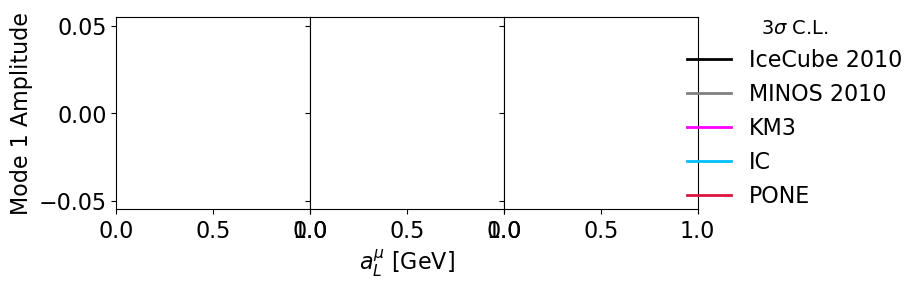

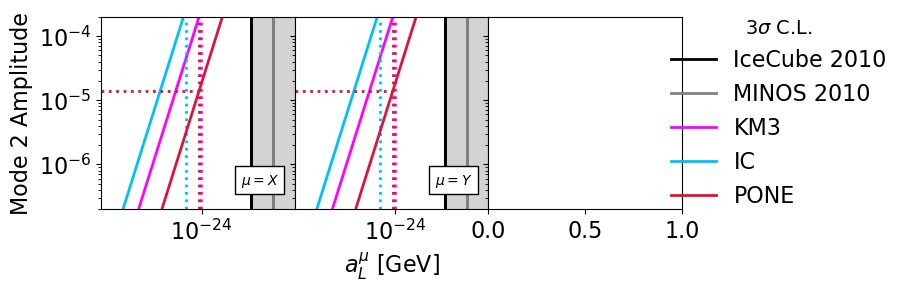

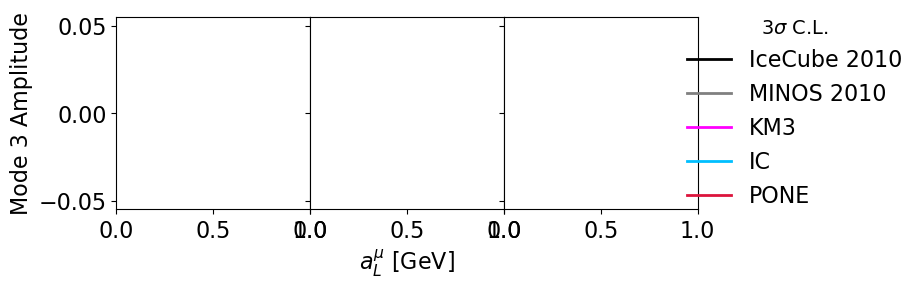

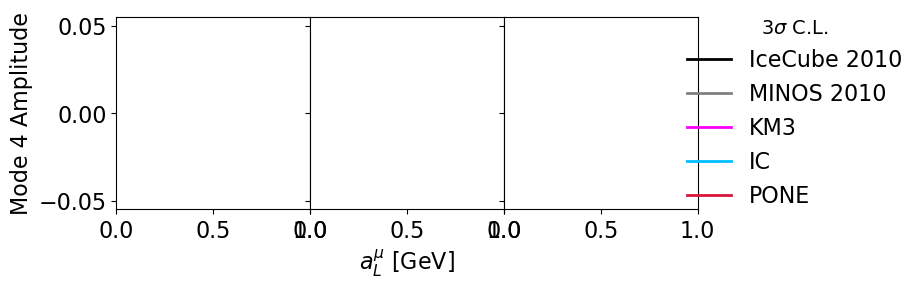

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_2552/1153663391.py:66: RuntimeWarning: invalid value encountered in scalar divide
  if (amps_per_cL[-1]/amps_per_cL[0] < 10): continue
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_2552/2188895235.py:5: RuntimeWarning: divide by zero encountered in log10
  coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))


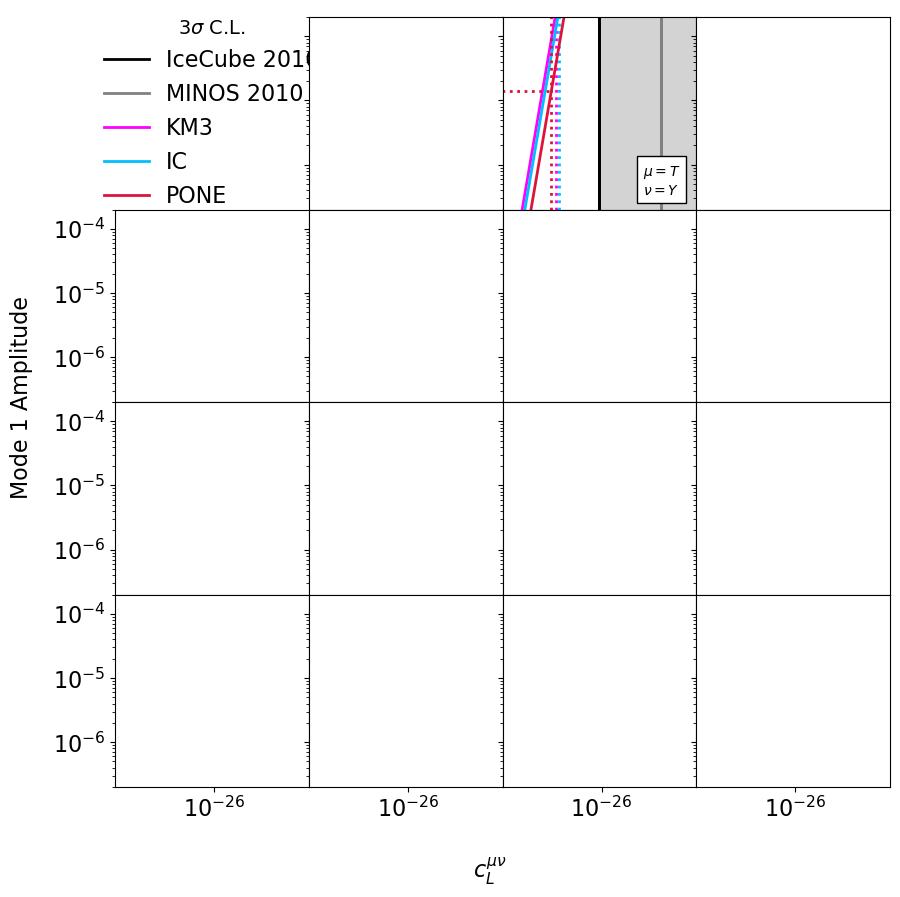

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_2552/1153663391.py:66: RuntimeWarning: invalid value encountered in scalar divide
  if (amps_per_cL[-1]/amps_per_cL[0] < 10): continue
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_2552/2188895235.py:5: RuntimeWarning: divide by zero encountered in log10
  coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))


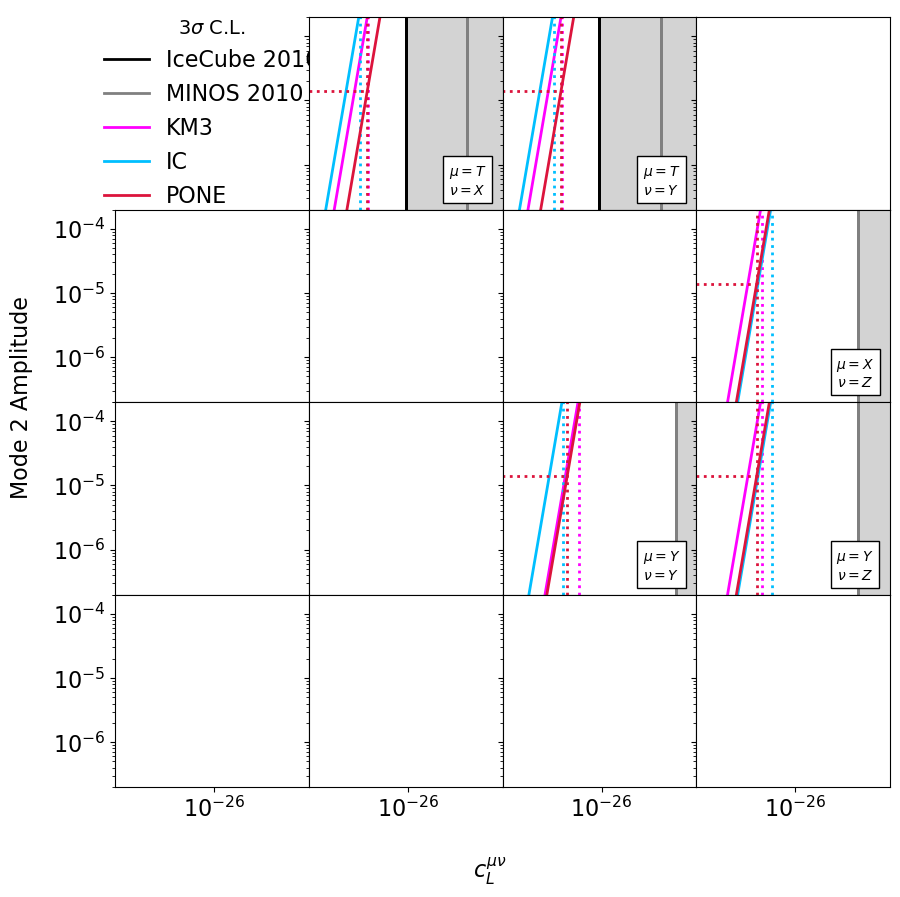

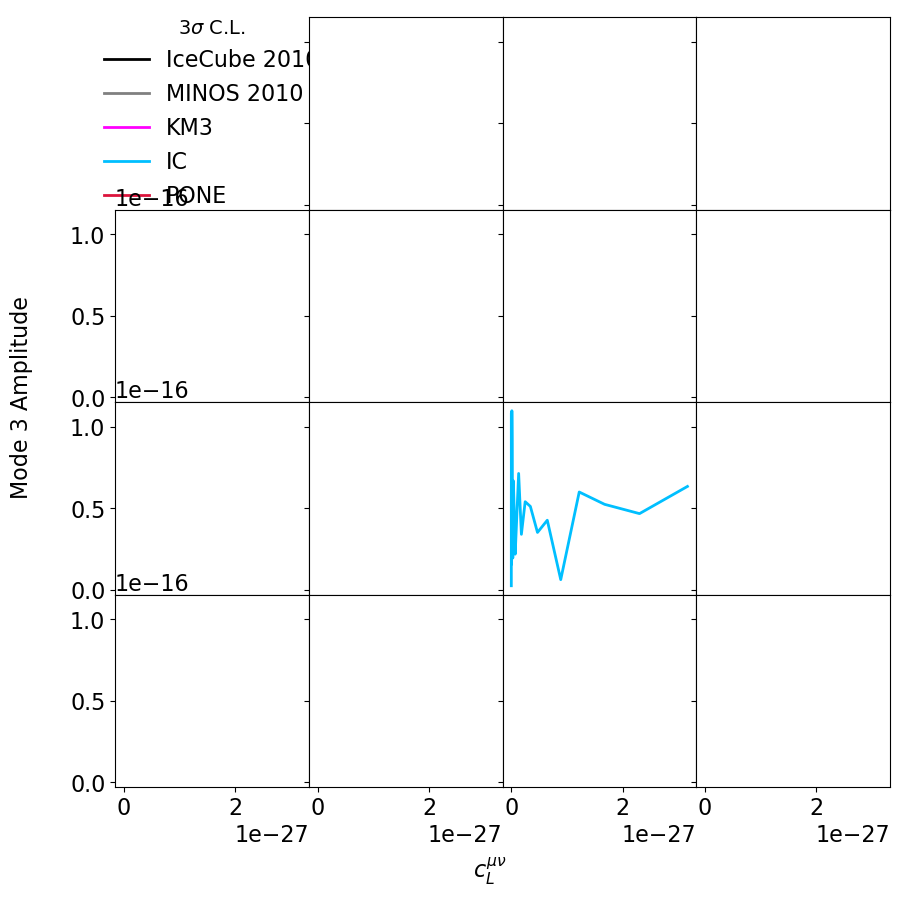

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_2552/1153663391.py:66: RuntimeWarning: invalid value encountered in scalar divide
  if (amps_per_cL[-1]/amps_per_cL[0] < 10): continue
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_2552/2188895235.py:5: RuntimeWarning: divide by zero encountered in log10
  coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))


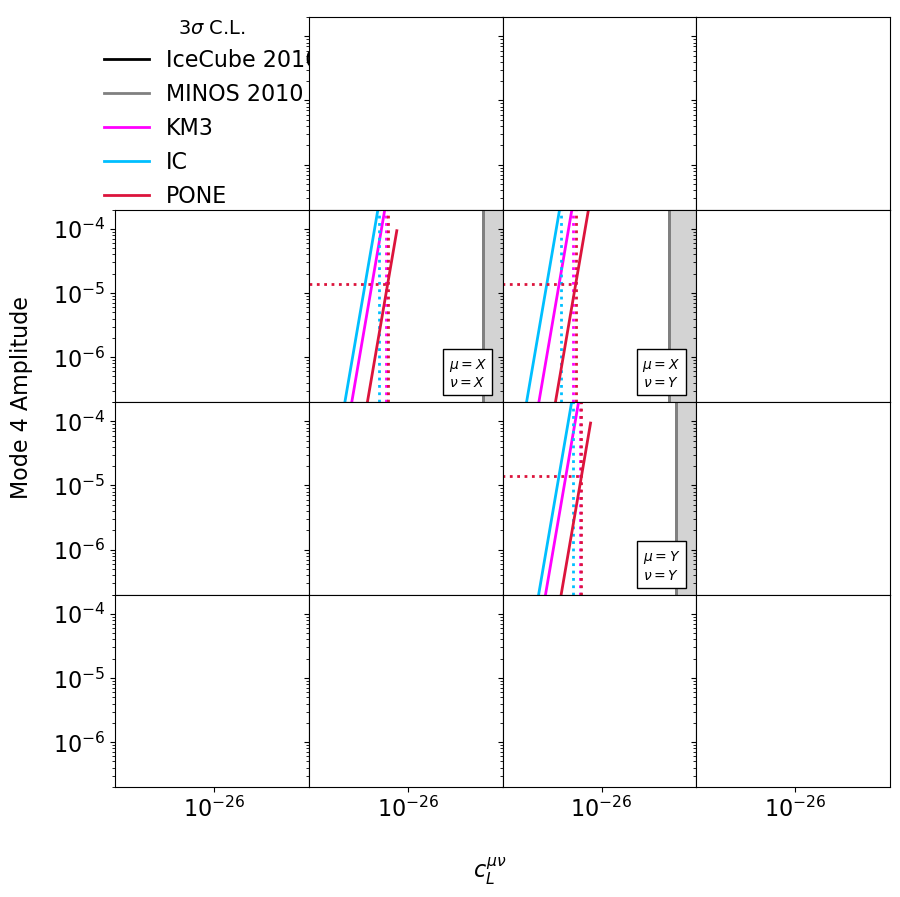

In [104]:




for mode in [1,2,3,4]:
    fig,ax = plt.subplots(1,4,sharey=True,figsize=(10,2.5))
    plt.subplots_adjust(wspace=0)
    ax[-1].axis("Off")
    ax[0].set_ylabel("Mode %d Amplitude"%mode,fontsize=16)
    ax[1].set_xlabel(r"$a_L^\mu$ [GeV]",fontsize=16)
    ax[-1].plot([],[],color="black",ls="-",label="IceCube 2010")
    ax[-1].plot([],[],color="gray",ls="-",label="MINOS 2010")
    for exp in experiment_list:
        amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
        ax[-1].plot([],[],color=color_list[exp],label=exp)
        for pos in [1,2,3]:
            amps_per_aL = [aL_amps[(exp,pos,aL)][mode] for aL in aL_range]
            if (amps_per_aL[-1]/amps_per_cL[0] < 10): continue
            ax[pos-1].plot(aL_range,amps_per_aL,color=color_list[exp])
            plot_upper_limit(amp_upper_limit,aL_range,amps_per_aL,ax[pos-1],color_list[exp])
            
            # IceCube limits
            if pos in IC_upper_limit_aL.keys():
                ax[pos-1].plot([IC_upper_limit_aL[pos],IC_upper_limit_aL[pos]],
                               [amp_min,amp_max],color="black",ls="-")
                ax[pos-1].fill_betweenx([amp_min,amp_max],
                                        x1=IC_upper_limit_aL[pos],
                                        x2=aL_max,
                                        color="lightgray")
            # MINOS limits
            if pos in MINOS_upper_limit_aL.keys():
                ax[pos-1].plot([MINOS_upper_limit_aL[pos],MINOS_upper_limit_aL[pos]],
                               [amp_min,amp_max],color="gray",ls="-")
                ax[pos-1].fill_betweenx([amp_min,amp_max],
                                        x1=MINOS_upper_limit_aL[pos],
                                        x2=aL_max,
                                        color="lightgray")
                
            if exp=="IC":
                ax[pos-1].text(0.82,0.15,r"$\mu = %s$"%lorentz_index[pos],
                           horizontalalignment='center', verticalalignment='center', 
                           transform=ax[pos-1].transAxes,
                           bbox=dict(facecolor='white',edgecolor="black"))
                ax[pos-1].loglog()
                ax[pos-1].set_xlim(aL_range[0],aL_max)
                ax[pos-1].set_ylim(amp_min,amp_max)
    ax[-1].legend(title=r"$3\sigma$ C.L.",loc="center")
    #plt.tight_layout()
    plt.savefig("figures/LV_aL_mode%d.pdf"%mode,dpi=100,bbox_inches='tight')
    plt.show()




for mode in [1,2,3,4]:
    fig,ax = plt.subplots(4,4,sharey=True,sharex=True,figsize=(10,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    ax[0,0].axis("off")
    fig.supylabel("Mode %d Amplitude"%mode,fontsize=16)
    fig.supxlabel(r"$c_L^{\mu \nu}$",fontsize=16)
    ax[0,0].plot([],[],color="black",ls="-",label="IceCube 2010")
    ax[0,0].plot([],[],color="gray",ls="-",label="MINOS 2010")
    for exp in experiment_list:
        amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
        ax[0,0].plot([],[],color=color_list[exp],label=exp)
        for pos1 in range(4):
            for pos2 in range(4):
                if pos1==0 and pos2==0: continue
                amps_per_cL = [cL_amps[(exp,pos1,pos2,cL)][mode] for cL in cL_range]
                if (amps_per_cL[-1]/amps_per_cL[0] < 10): continue
                try:
                    ax[pos1,pos2].plot(cL_range,amps_per_cL,color=color_list[exp])
                    plot_upper_limit(amp_upper_limit,cL_range,amps_per_cL,ax[pos1,pos2],color_list[exp])
    
                    # IceCube limits 
                    if (pos1,pos2) in IC_upper_limit_cL.keys():
                        ax[(pos1,pos2)].plot([IC_upper_limit_cL[(pos1,pos2)],IC_upper_limit_cL[(pos1,pos2)]],
                                       [amp_min,amp_max],color="black",ls="-")
                        ax[(pos1,pos2)].fill_betweenx([amp_min,amp_max],
                                                x1=IC_upper_limit_cL[(pos1,pos2)],
                                                x2=cL_max,
                                                color="lightgray")
                    # MINOS limits 
                    if (pos1,pos2) in MINOS_upper_limit_cL.keys():
                        ax[(pos1,pos2)].plot([MINOS_upper_limit_cL[(pos1,pos2)],MINOS_upper_limit_cL[(pos1,pos2)]],
                                       [amp_min,amp_max],color="gray",ls="-")
                        ax[(pos1,pos2)].fill_betweenx([amp_min,amp_max],
                                                x1=MINOS_upper_limit_cL[(pos1,pos2)],
                                                x2=cL_max,
                                                color="lightgray")
                        
                    if exp=="IC":
                        ax[pos1,pos2].text(0.82,0.15,r"$\mu = %s$"%lorentz_index[pos1]+"\n"+r"$\nu = %s$"%lorentz_index[pos2],
                                           horizontalalignment='center', verticalalignment='center', 
                                           transform=ax[pos1,pos2].transAxes,
                                           bbox=dict(facecolor='white',edgecolor="black"))
                        ax[pos1,pos2].loglog()
                        ax[pos1,pos2].set_xlim(cL_range[0],cL_max)
                        ax[pos1,pos2].set_ylim(amp_min,amp_max)
                except:
                    pass
    ax[0,0].legend(title=r"$3\sigma$ C.L.",loc="center")
    plt.savefig("figures/LV_cL_mode%d.pdf"%mode,dpi=100,bbox_inches='tight')
    plt.show()